# Car Classification Model

In [ ]:
# Transfer Learning using EfficientNet

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image

In [3]:
base_model=tf.keras.applications.EfficientNetB0(input_shape=(224,224,3),include_top=False)

In [5]:
base_model.trainable=False # Freezing the Convolution layers

In [6]:
base_model.trainable

False

In [7]:
transfer_model=Sequential([base_model,Flatten(),
                            BatchNormalization(),
            Dense(units=512,activation='relu'),
                           BatchNormalization(),
            Dense(units=64,activation='relu'),
                           BatchNormalization(),
            Dense(units=10,activation='softmax')])

In [8]:
transfer_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 62720)             250880    
_________________________________________________________________
dense (Dense)                (None, 512)               32113152  
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                2

In [9]:
#Augmentation
train_datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
                  rotation_range=45,
                  width_shift_range=0.2,
                  height_shift_range=0.2,
                  shear_range=0.2,
                  zoom_range=0.2,
                  horizontal_flip=True,
                  fill_mode='reflect')

test_datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

In [10]:
train_set=train_datagen.flow_from_directory('./cars_type1/train',
                                           target_size=(224,224),
                                           batch_size=64,
                                           class_mode='categorical')
test_set=test_datagen.flow_from_directory('./cars_type1/val',
                                           target_size=(224,224),
                                           batch_size=64,
                                           class_mode='categorical')

Found 5696 images belonging to 10 classes.
Found 2448 images belonging to 10 classes.


In [11]:
transfer_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

keras_callback=[EarlyStopping(monitor='val_loss',mode='min',patience=10,min_delta=0.01),
               ModelCheckpoint('./car_model_weights_BN',monitor='val_loss',mode='min',save_best=True)]

In [13]:
history=transfer_model.fit(train_set,steps_per_epoch=train_set.samples//64,epochs=20,
                   validation_data=test_set,validation_steps=test_set.samples//64,callbacks=keras_callback)

Epoch 1/20
89/89 [==============================] - ETA: 0s - loss: 1.9231 - accuracy: 0.3515WARNING:tensorflow:From C:\Users\sree_\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: .\car_model_weights_BN\assets
89/89 [==============================] - 507s 6s/step - loss: 1.9231 - accuracy: 0.3515 - val_loss: 1.5103 - val_accuracy: 0.5399
Epoch 2/20
89/89 [==============================] - 448s 5s/step - loss: 1.5067 - accuracy: 0.4814 - val_loss: 1.1996 - val_accuracy: 0.5917
Epoch 3/20
89/89 [==============================] - 405s 5s/step - loss: 1.3730 - a

In [14]:
class_name=train_set.class_indices
class_name

{'Cab': 0,
 'Convertible': 1,
 'Coupe': 2,
 'Hatchback': 3,
 'Minivan': 4,
 'Other': 5,
 'SUV': 6,
 'Sedan': 7,
 'Van': 8,
 'Wagon': 9}

In [15]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

dire='./cars_type1/example/'
filename=os.listdir(dire)
images=[]
for i in filename:
    img=cv2.imread(dire+i)
    images.append(cv2.resize(img,(224,224)))

class_name=train_set.class_indices  
images_ar=np.array(images)
images_ar=tf.keras.applications.efficientnet.preprocess_input(images_ar)

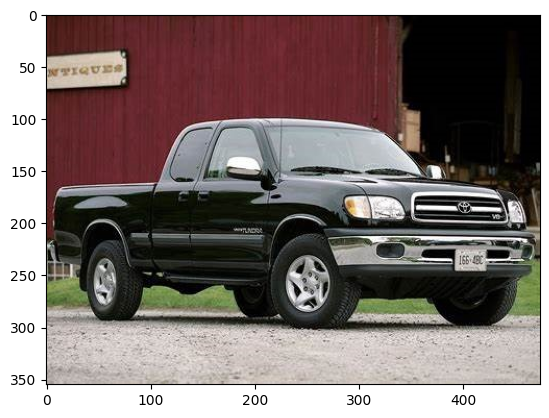

cab1.jpeg Cab


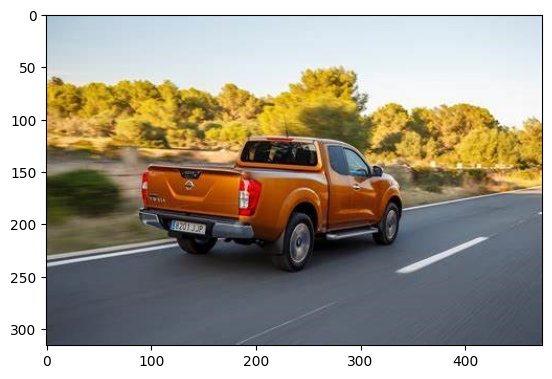

cab2.jpeg Cab


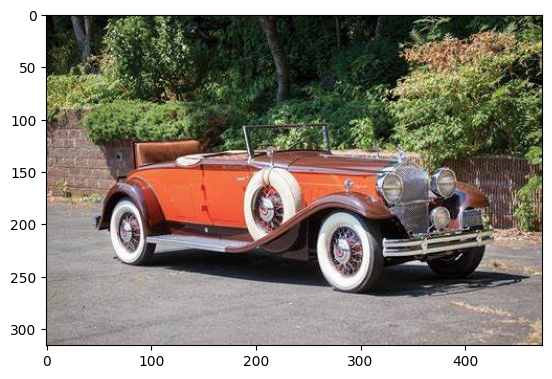

convertible1.jpeg Convertible


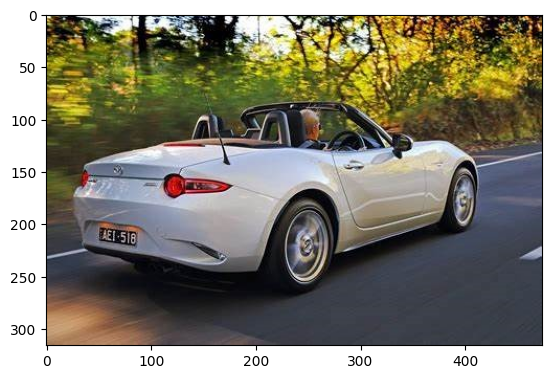

convertible2.jpeg Convertible


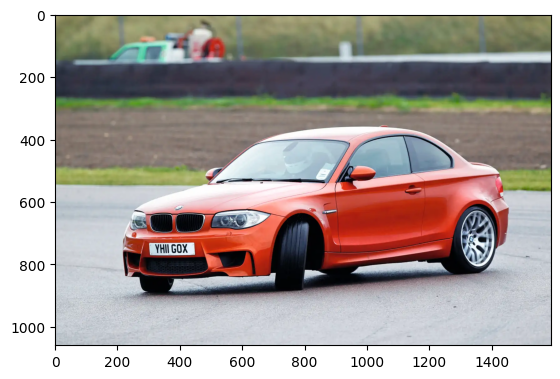

Coupe2.jpg Other


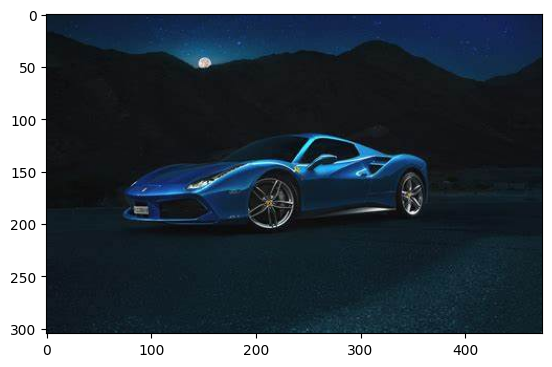

Ferrari coupe.jfif Coupe


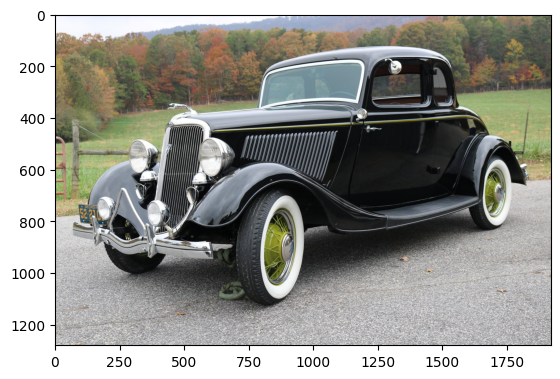

ford-5-window-coupe.jpg Cab


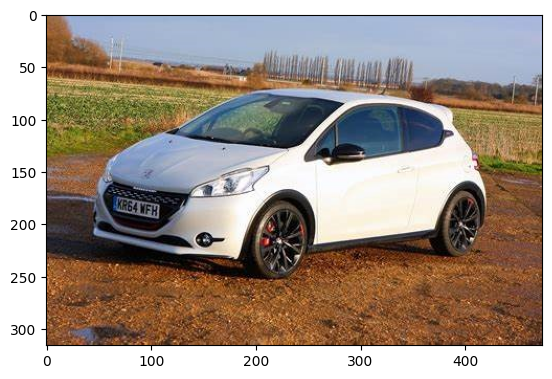

hatchback1.jpg Sedan


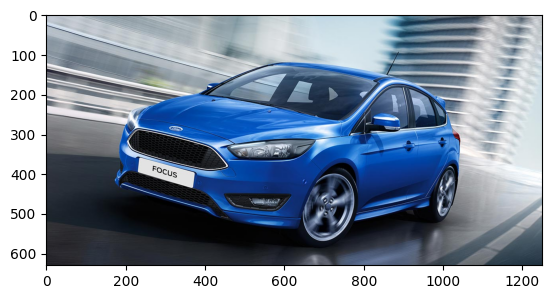

hatchback2.jpeg Sedan


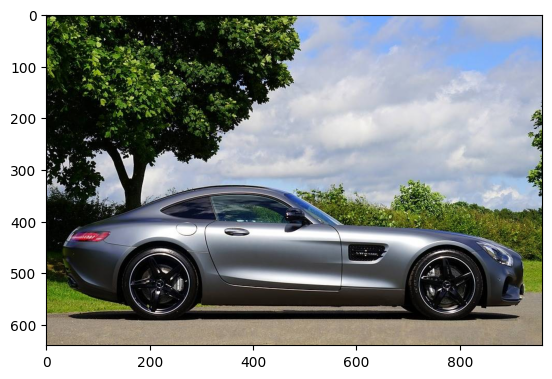

Mersedes Benz coupe.jpg Sedan


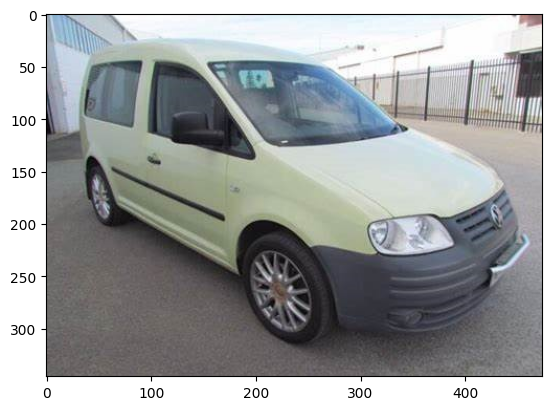

minivan.jpeg Minivan


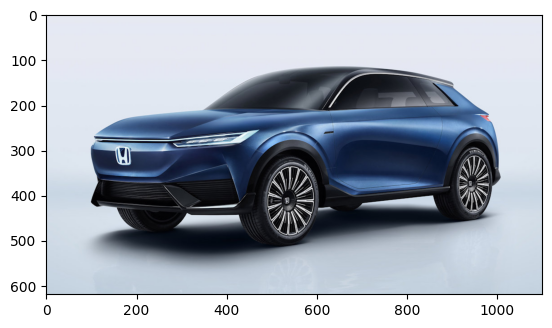

suv.jpg Sedan


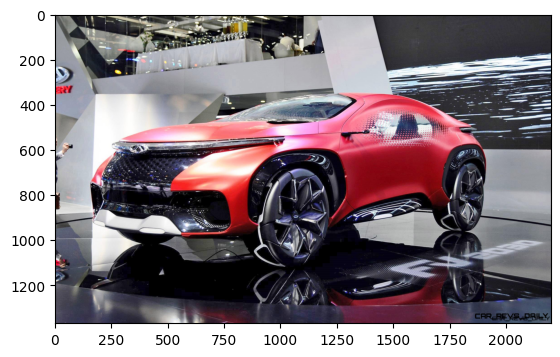

suv1.jpg Other


In [16]:
yprob=transfer_model.predict(images_ar)

for j in range(len(yprob)):
    pos=np.array(list(class_name.values()))==yprob[j].argmax()
    img=cv2.imread(dire+filename[j])
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()
    name=np.array(list(class_name.keys()))
    print(filename[j],name[pos][0])

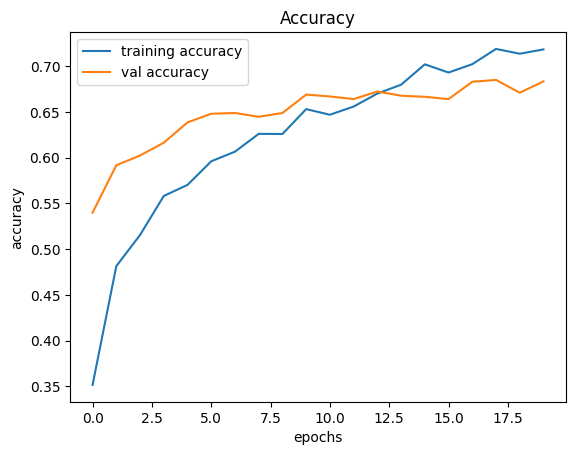

In [17]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()